# NFS Script - Static

In [1]:
import sys
sys.path.append('C:/Users/smithlab/Documents/Aaron/Modules/')
import numpy as np
from matplotlib import pyplot as plt
import VNA_control as vc
import calibration_functions as cf
import gclib
import stage_control as sc
import scipy.constants
import scipy.io
import time
import datetime

C     = scipy.constants.c
EPS_0 = scipy.constants.epsilon_0 #C^2/(N*m^2)
MU_0  = scipy.constants.mu_0    #m kg s^-2 A^-2
mm = 0.001
cm    = 0.01
GHz   = 1.0E9

## Scan parameters

In [2]:
xrange = 1000 # x length of stage, mm
yrange = 1000 # y length of stage, mm

fstart = 8E9
fstop = 12E9
NumFreqs = 401
f = np.linspace(fstart, fstop, NumFreqs)
lam_max = C/fstop
dstep = lam_max/2 * 1000 # mm

IFBW = 1000
calfile = 'Aaron_21-11-05'
power = 0
savename = 'X_Band_Horn_copol'
sParMeas = 'S12'
speedmms = 25

print('IFBW = {} \nCalibration File = {} \nPower = {} dBm \nMeasuring {}'.format(IFBW, calfile, power, sParMeas))

IFBW = 1000 
Calibration File = Aaron_21-11-05 
Power = 0 dBm 
Measuring S12


## Set scan lengths

In [3]:
Lx_ap = 30;
Ly_ap = 40;
theta = 60;
d = 80;

Lx_scan = Lx_ap + 2*d*np.tan(np.radians(theta));
Ly_scan = Ly_ap + 2*d*np.tan(np.radians(theta));

xmin = -Lx_scan/2;
xmax = Lx_scan/2;
ymin = -Ly_scan/2;
ymax = Ly_scan/2;

## Initialize instruments

In [4]:
## Stage
g = sc.stage_start('169.254.225.173')
sc.stage_home(g,speedmms)

## VNA
vna = vc.instrument_open('TCPIP0::169.254.187.153::5025::SOCKET')
vc.VNA_initiate(vna, NumFreqs, fstart*1E-9, fstop*1E-9, IFBW, power, 'S12', calfile=calfile)

Agilent Technologies,N5222A,MY51421573,A.09.90.10
Initiating VNA...

Done



## Move to new origin

In [17]:
center_x = -xrange/2;
center_y = -yrange/2;
pos_x = 227#+30/2;  # adjust to change x zero position
pos_y = -37#+40/2;  # adjust to change y zero position

sc.move_to_absolute(g,speedmms,0,0,center_x+pos_x,center_y+pos_y)

(-273.0, -537.0)

## Zero axes

In [18]:
defZeroInXsteps, defZeroInYsteps = sc.zero_axes(g);

## Setup scan

In [19]:
X, Y = np.meshgrid(np.arange(xmin, xmax, dstep), np.arange(ymin, ymax, dstep), indexing='xy')
measurements = np.zeros((Y.shape[0], X.shape[1], NumFreqs), dtype=np.complex128)
stops = Y.shape[0] * X.shape[1]

## Start scan

In [20]:
sc.move_to_absolute(g,speedmms,defZeroInXsteps,defZeroInYsteps,X[0,0],Y[0,0])

(-153.564, -158.564)

In [21]:
t = time.time()
stopscomp = 0

x_list = []
y_list = []
for yn in range(Y.shape[0]):
    direction = 2*np.mod(yn+1, 2) - 1
    if direction > 0:
        xindex = np.arange(X.shape[1])
    else:
        xindex = np.flip(np.arange(X.shape[1]))
        
    for xn in xindex:
        x = X[yn, xn]
        y = Y[yn, xn]
        sc.move_to_absolute(g,speedmms,defZeroInXsteps,defZeroInYsteps,x,y)
        
        measurements[yn,xn,:] = vc.VNA_read(vna, sParMeas)
        
        stopscomp += 1
        timere = (stops - stopscomp) * (time.time()-t)/3600
        if stopscomp%10==0:
            print('Est. time remaining: {} hours'.format(timere))
        t = time.time()


Est. time remaining: 0.2873103247748481 hours
Est. time remaining: 0.28571527600288393 hours
Est. time remaining: 0.284628783331977 hours
Est. time remaining: 0.27411623332235546 hours
Est. time remaining: 0.2693685293197632 hours
Est. time remaining: 0.26745220422744753 hours
Est. time remaining: 0.26292046043607925 hours
Est. time remaining: 0.255890816450119 hours
Est. time remaining: 0.2538116614023844 hours
Est. time remaining: 0.24766211046112907 hours
Est. time remaining: 0.24254583120346068 hours
Est. time remaining: 0.2379326535595788 hours
Est. time remaining: 0.23641393184661866 hours
Est. time remaining: 0.22890150745709736 hours
Est. time remaining: 0.22274255752563477 hours
Est. time remaining: 0.2199594411585066 hours
Est. time remaining: 0.2179766019185384 hours
Est. time remaining: 0.21099685033162435 hours
Est. time remaining: 0.20735462374157376 hours
Est. time remaining: 0.20603477954864502 hours
Est. time remaining: 0.19739844799041747 hours
Est. time remaining: 0.

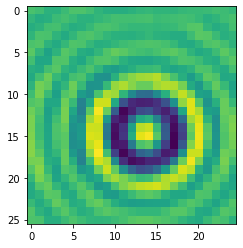

In [27]:
plt.imshow(np.real(measurements[:,:,0]))
plt.show()

## Save data

In [23]:
savepath = 'C:/Users/smithlab/Documents/Near_Field_Scans/'
scipy.io.savemat('{}{}_{}.mat'.format(savepath, savename, datetime.datetime.now().strftime('%Y-%m-%d')),
                                      {'X': X,
                                       'Y': Y,
                                       'f': f,
                                       'measurements': measurements})

## Clean up communications

In [24]:
sc.close_connection(g)
vna.close()

Controller connection stopped
